In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import FashionMNIST
from torchvision import transforms

from random import randint
from tqdm import tqdm

import matplotlib.pyplot as plt

In [8]:
print(torch.backends.mps.is_available())
print(torch.cuda.is_available())
#device = torch.device("cpu")
device = torch.device("cuda")

False
True


In [238]:
BS = 256

In [37]:
t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset_train = FashionMNIST(root="../datasets/", train=True, download=True, transform=t)
dataset_test = FashionMNIST(root="../datasets/", train=False, download=True, transform=t)

In [239]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=BS, shuffle=False)

In [185]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(11, 11), stride=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=(2,2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [186]:
device = torch.device(device)
model = alexnet().to(device)

In [246]:
N_EPOCHS = 5

B_EPOCHS = int(60_000 / BS)

optim = torch.optim.SGD(params=model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss()
#loss_fn = nn.CrossEntropyLoss()
def acc_fn(pred, target):
  return (pred.argmax(dim=1)==target).sum()

In [247]:
losses = []
accs = []

prog_bar = tqdm(range(N_EPOCHS), position=0)

for e in prog_bar:
    for i, (x, y) in enumerate(train_dataloader):
        optim.zero_grad()
        pred = model(x.to(device))

        loss = loss_fn(pred, y.to(device))
        if len(losses) > 1 and i % 5 == 0:
            prog_bar.set_description(str(loss.item()/BS/losses[len(losses)-1]))
                                     
        losses.append(loss.item()/BS)
        

        acc = acc_fn(pred.detach().cpu(), y.detach().cpu())
        accs.append(acc.item()/BS)

        loss.backward()
        optim.step()
    
        if i % 150 == 0: 
            print(f"Epoch: {e} --- {i}/{B_EPOCHS} --- Loss: {loss.item()/BS} --- Acc: {acc.item()/BS}")

  0%|                                                                                                                             | 0/5 [00:00<?, ?it/s]

Epoch: 0 --- 0/234 --- Loss: 0.0009527470101602376 --- Acc: 0.92578125


0.9866506913466442:   0%|                                                                                                         | 0/5 [00:12<?, ?it/s]

Epoch: 0 --- 150/234 --- Loss: 0.0009552047122269869 --- Acc: 0.90234375


0.8641359820865783:  20%|███████████████████▍                                                                             | 1/5 [00:19<01:19, 19.85s/it]

Epoch: 1 --- 0/234 --- Loss: 0.0007800383027642965 --- Acc: 0.921875


0.8603519176883632:  20%|███████████████████▍                                                                             | 1/5 [00:31<02:06, 31.50s/it]


KeyboardInterrupt: 

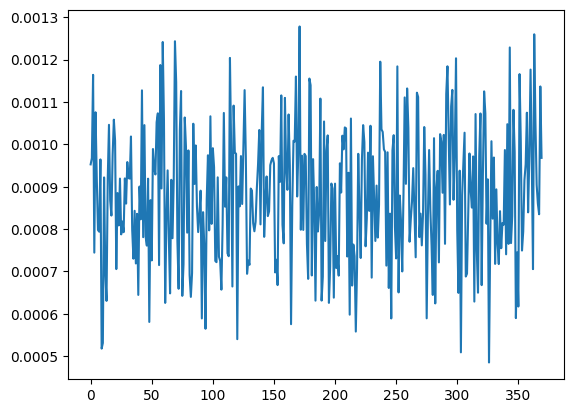

In [248]:
plt.plot(losses)
#plt.plot(accs)

In [249]:
model.eval()
score = 0
for x, y in test_dataloader:
  score += acc_fn(model(x.to(device)).detach().cpu(), y)
print(score)

tensor(9001)
